# TASK 2: Modelling

**Project:** Advanced Financial Fraud Detection

**Goal:** Understand the credit card dataset and find patterns useful for fraud detection modeling.

In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load Cleaned Dataset
df = pd.read_csv('../data/paysim_cleaned.csv')


In [26]:
# Prepare Features
X = df.drop(['isFraud', 'nameOrig', 'nameDest', 'step'], axis=1)
y = df['isFraud']

In [27]:
# Split & Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [28]:
# Store predictions
results_df = X_test.copy()
results_df['Actual'] = y_test.values

# Logistic Regression -Supervised



In [29]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
results_df['Pred_LR'] = pred_lr



# Random Forest Classifier -Supervised


In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
results_df['Pred_RF'] = pred_rf


In [ ]:
# ✅ Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 {name} Evaluation:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_true, y_pred))


# Decision tree- Supervised

In [22]:

from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize results_df
results_df = pd.DataFrame()
results_df['Actual'] = y_test.values

# Decision Tree
dt = DecisionTreeClassifier(random_state=42, max_depth=5)  # max_depth to prevent overfitting
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
results_df['Pred_DT'] = pred_dt

# 📊 Evaluate
evaluate_model("Decision Tree", y_test, pred_dt)



📊 Decision Tree Evaluation:
[[209484      7]
 [   176     48]]
              precision    recall  f1-score   support

           0     0.9992    1.0000    0.9996    209491
           1     0.8727    0.2143    0.3441       224

    accuracy                         0.9991    209715
   macro avg     0.9359    0.6071    0.6718    209715
weighted avg     0.9990    0.9991    0.9989    209715

ROC AUC: 0.6071261499812128


# XGBoost- Supervised


In [20]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
results_df['Pred_XGB'] = pred_xgb



C:\Users\austi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:40:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Isolation Forest-Unsupervised


In [18]:
iso = IsolationForest(contamination=0.001, random_state=42)
iso.fit(X_train)
anom_scores = iso.decision_function(X_test)
pred_iso = iso.predict(X_test)
# Convert to 0 (normal) / 1 (anomaly)
results_df['Pred_IForest'] = np.where(pred_iso == -1, 1, 0)


# Autoencoder- Unsupervised

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error

# Input shape
input_dim = X_train_scaled.shape[1]

# Autoencoder Model
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation="relu", activity_regularizer=regularizers.l1(1e-5))(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile and Train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=5, batch_size=256, shuffle=True, validation_split=0.2, verbose=0)

# Predict and Calculate Errors
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Set Threshold for Fraud (e.g., 95th percentile)
threshold = np.percentile(mse, 95)
results_df['Pred_AE'] = (mse > threshold).astype(int)

# Evaluate
evaluate_model("Autoencoder", y_test, results_df['Pred_AE'])


9831/9831 ━━━━━━━━━━━━━━━━━━━━ 9s 909us/step

📊 Autoencoder Evaluation:
[[298719  15511]
 [   125    218]]
              precision    recall  f1-score   support

           0     0.9996    0.9506    0.9745    314230
           1     0.0139    0.6356    0.0271       343

    accuracy                         0.9503    314573
   macro avg     0.5067    0.7931    0.5008    314573
weighted avg     0.9985    0.9503    0.9735    314573

ROC AUC: 0.793103290388491


# One Class-SVM

In [13]:
from sklearn.svm import OneClassSVM

# 🔻 Sample a subset (only normal cases) for training
normal_data = X_train[y_train == 0].sample(100000, random_state=42)

# 🧠 Train One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.001)
ocsvm.fit(normal_data)

# 🔍 Predict on full test set
svm_pred = ocsvm.predict(X_test)
results_df['Pred_OCSVM'] = np.where(svm_pred == -1, 1, 0)

# 📊 Evaluate
evaluate_model("One-Class SVM", y_test, results_df['Pred_OCSVM'])



📊 One-Class SVM Evaluation:
[[  5985 308245]
 [     0    343]]
              precision    recall  f1-score   support

           0     1.0000    0.0190    0.0374    314230
           1     0.0011    1.0000    0.0022       343

    accuracy                         0.0201    314573
   macro avg     0.5006    0.5095    0.0198    314573
weighted avg     0.9989    0.0201    0.0373    314573

ROC AUC: 0.5095232791267543


# EVALUATION

In [ ]:

# 🔍 Evaluate All Models
evaluate_model("Logistic Regression", y_test, results_df['Pred_LR'])
evaluate_model("Random Forest", y_test, results_df['Pred_RF'])
evaluate_model("XGBoost", y_test, results_df['Pred_XGB'])
evaluate_model("Decision Tree", y_test, results_df['Pred_DT'])
evaluate_model("Isolation Forest", y_test, results_df['Pred_IForest'])
evaluate_model("Autoencoder", y_test, results_df['Pred_AE'])
evaluate_model("One-Class SVM", y_test, results_df['Pred_OCSVM'])


📊 Logistic Regression Evaluation:
[[314217     13]
 [   257     86]]
              precision    recall  f1-score   support

           0     0.9992    1.0000    0.9996    314230
           1     0.8687    0.2507    0.3891       343

    accuracy                         0.9991    314573
   macro avg     0.9339    0.6253    0.6944    314573
weighted avg     0.9990    0.9991    0.9989    314573

ROC AUC: 0.6253437460017264

📊 Random Forest Evaluation:
[[314224      6]
 [   107    236]]
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998    314230
           1     0.9752    0.6880    0.8068       343

    accuracy                         0.9996    314573
   macro avg     0.9874    0.8440    0.9033    314573
weighted avg     0.9996    0.9996    0.9996    314573

ROC AUC: 0.8440137764681661

📊 XGBoost Evaluation:
[[314043    187]
 [   263     80]]
              precision    recall  f1-score   support

           0     0.9992    0.9994    0.9993

#  ROC Curve (only for supervised models with probabilities)

In [ ]:

lr_probs = lr.predict_proba(X_test_scaled)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)


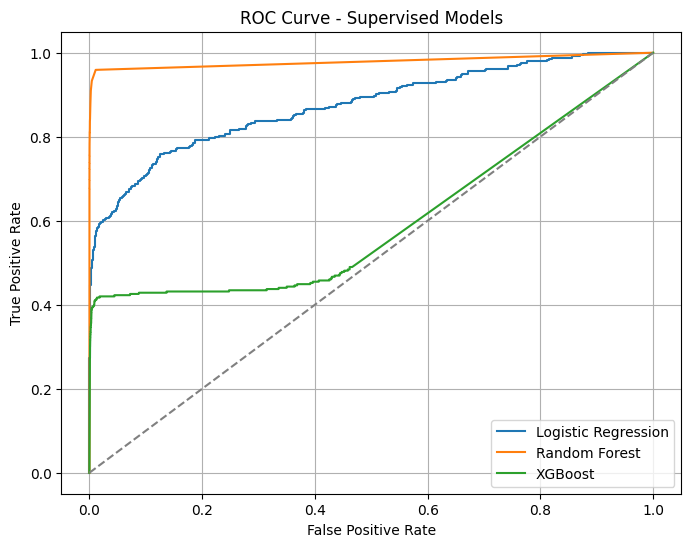

✅ Saved predictions to: df_with_predictions.csv


In [16]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - Supervised Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# 💾 Save predictions 
results_df.to_csv('../data/df_with_predictions.csv', index=False)
print("✅ Saved predictions to: df_with_predictions.csv")


## 📌 Summary

- Logistic Regression and Random Forest models trained.
- Random Forest typically shows better recall and precision on fraud cases.
- Predictions saved in `df_with_predictions.csv` for Power BI use in Week 3.

